# Computation of annotation enrichment in a genetic set 

This code excerpt shows how to use the annotation enrichment computation function in a genetic set.
The funciton return a dataframe of binom and hypergeometric p-value (<= 0.05) and for each p-value a fdr correction with alpha = 0.05.   

In the second part of the code we will compare the results obtained with the Great webserver and between the binomial and hypergeometric probability

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import greatpy as great
import pandas as pd
from math import inf
from numpy import log,nan, int64,cov,corrcoef
from scipy.stats import pearsonr
from seaborn import scatterplot as sp

import warnings
warnings.filterwarnings('ignore')

## I Compute the p-values

In [3]:
test = "../data/tests/test_data/input/10_MAX.bed"
regdom = "../data/human/hg38/regulatory_domain.bed"
great_out = "../data/tests/test_data/output/10_MAX_output_great_webserver.tsv"
great_asso = "../data/tests/test_data/output/10_MAX_gene_asso.tsv"
size = "../data/human/hg38/chr_size.bed"

In [4]:
enrichment = great.tl.GREAT.enrichment(
    test_file=test,
    regdom_file=regdom,
    chr_size_file=size,
    annotation_file="../data/human/ontologies.csv",
    binom=True,
    hypergeom=True,
    )
great.tl.GREAT.set_fdr(enrichment)
great.tl.GREAT.set_bonferroni(enrichment)
enrichment

,go_term,binom_p_value,binom_fold_enrichment,hypergeom_p_value,hypergeometric_fold_enrichment,binom_fdr,hypergeom_fdr,binom_bonferroni,hypergeom_bonferroni
GO:0015727,lactate transport,7.60590e-06,1.24703e+05,2.30069e-02,4.34653e+01,2.27873e-02,2.55291e-01,2.27873e-02,1.00000e+00
GO:0030574,collagen catabolic process,6.55513e-05,2.19762e+03,4.78304e-03,4.52763e+00,9.70693e-02,2.55291e-01,1.96392e-01,1.00000e+00
GO:0009925,basal plasma membrane,9.71989e-05,2.04379e+03,1.11533e-04,7.67034e+00,9.70693e-02,9.80092e-02,2.91208e-01,3.34152e-01
GO:0001664,G protein-coupled receptor binding,1.34590e-04,1.56274e+03,1.02889e-02,3.25990e+00,1.00808e-01,2.55291e-01,4.03231e-01,1.00000e+00
GO:0051403,stress-activated MAPK cascade,1.88598e-04,2.37466e+03,2.34952e-02,4.82948e+00,1.13008e-01,2.56904e-01,5.65039e-01,1.00000e+00
...,...,...,...,...,...,...,...,...,...
GO:0060271,cilium assembly,9.69389e-01,7.04877e+01,9.96710e-01,1.78136e-01,9.70685e-01,1.00000e+00,1.00000e+00,1.00000e+00
GO:0018105,peptidyl-serine phosphorylation,9.71387e-01,6.91582e+01,9.91356e-01,2.14115e-01,9.72361e-01,1.00000e+00,1.00000e+00,1.00000e+00
GO:0005768,endosome,9.79136e-01,8.51959e+01,9.94962e-01,2.74229e-01,9.79790e-01,1.00000e+00,1.00000e+00,1.00000e+00
GO:0007420,brain development,9.87730e-01,7.70685e+01,9.58504e-01,4.08125e-01,9.88060e-01,9.78092e-01,1.00000e+00,1.00000e+00


## II Compare to GREAT webserver  

### II.1 Import the data

In [5]:
great_webserver = pd.read_csv("../data/tests/test_data/output/02_srf_hg38_output_great_webserver.tsv",sep="\t",comment="#",
                    names=["ontologie","term_name","ID","binom_p_value","binom_bonferroni","binom_fdr","hyper_p_value","hyper_bonferroni","hyper_fdr"],index_col=False,
                    dtype={"term_name":"object", "ID":"object","binom_p_value":"float64", "binom_bonferroni":"float64", "binom_fdr":"float64", "hyper_p_value":"float64", "hyper_bonferroni":"float64", "hyper_fdr":"float64"})
great_webserver.rename(columns={"ID":"id"},inplace=True)
del great_webserver["ontologie"]
del great_webserver["term_name"]
great_webserver

,id,binom_p_value,binom_bonferroni,binom_fdr,hyper_p_value,hyper_bonferroni,hyper_fdr
0,GO:0098974,1.16271e-09,1.53001e-05,1.53001e-05,4.91559e-02,1.00000e+00,1.00000e+00
1,GO:0030035,6.86116e-08,9.02861e-04,3.00954e-04,1.82609e-01,1.00000e+00,1.00000e+00
2,GO:0002478,3.37650e-07,4.44314e-03,8.88627e-04,8.26639e-03,1.00000e+00,7.01790e-01
3,GO:0019884,5.84360e-07,7.68959e-03,1.09851e-03,1.19953e-02,1.00000e+00,7.85306e-01
4,GO:0048254,7.09959e-07,9.34235e-03,1.03804e-03,1.35530e-02,1.00000e+00,8.33383e-01
...,...,...,...,...,...,...,...
2676,GO:0090722,3.87433e-01,1.00000e+00,1.00000e+00,1.82609e-01,1.00000e+00,1.00000e+00
2677,GO:0031698,3.88983e-01,1.00000e+00,1.00000e+00,1.82609e-01,1.00000e+00,1.00000e+00
2678,GO:0046935,3.89202e-01,1.00000e+00,1.00000e+00,2.97348e-01,1.00000e+00,1.00000e+00
2679,GO:0015129,3.91083e-01,1.00000e+00,1.00000e+00,2.22797e-01,1.00000e+00,1.00000e+00


### II.2 Compare the results between greatpy and great 

#### II.2.1 Preprocessing

In [6]:
enrichment = enrichment[enrichment.index.isin(list(great_webserver["id"]))]
enrichment = enrichment.reset_index(drop=False).rename(columns={"index":"id"})
enrichment = enrichment.sort_values("id")

In [7]:
great_webserver = great_webserver[great_webserver["id"].isin(list(enrichment["id"]))]
great_webserver = great_webserver.sort_values("id")

In [8]:
binom_greatpy = []
hyper_greatpy = []
binom_great = []
hyper_great = []
for i in range(enrichment.shape[0]) : 
    curr_enrichment = enrichment.iloc[i]
    curr_great_webserver = great_webserver.loc[great_webserver["id"]==curr_enrichment["id"]]
    binom_greatpy.append(float(curr_enrichment["binom_p_value"]))
    hyper_greatpy.append(float(curr_enrichment["hypergeom_p_value"]))
    binom_great.append(float(curr_great_webserver["binom_p_value"]))
    hyper_great.append(float(curr_great_webserver["hyper_p_value"]))
binom = pd.DataFrame({"binom_greatpy":binom_greatpy,"binom_great":binom_great})
hyper = pd.DataFrame({"hyper_greatpy":hyper_greatpy,"hyper_great":hyper_great})

#### II.2.b Graphical

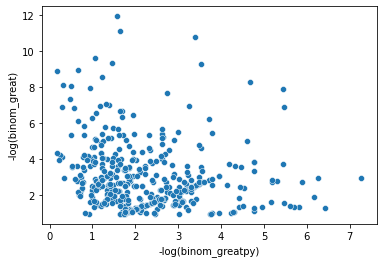

In [9]:
pl=great.pl.scatterplot(binom,colname_x="binom_greatpy",colname_y="binom_great")

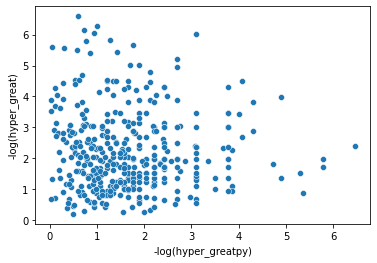

In [10]:
great.pl.scatterplot(hyper,colname_x="hyper_greatpy",colname_y="hyper_great")

#### II.2.c Statistics

In [11]:
def stat(binom_great_list_list, hyper_great_listpy_list,binom_great_list,hyper_great_list) : 
    return pd.DataFrame({
        "binom": [cov(m = binom_great_list_list, y = binom_great_list)[0][1],pearsonr(binom_great_list_list,binom_great_list)[0]],
        "hyper":[cov(m = hyper_great_listpy_list, y = hyper_great_list)[0][1],pearsonr(hyper_great_listpy_list,hyper_great_list)[0]]},
        index=["correlation_coefficient","pearson"])

In [12]:
stat(binom_greatpy, hyper_greatpy,binom_great,hyper_great)

,binom,hyper
correlation_coefficient,-4.18196e-03,1.07131e-03
pearson,-2.33984e-01,2.85191e-02


The result returned by greatpy is similar to the one obtained (pearson coefficient = 1) but the results have been reduced to select only the ids present in great_output and greatpy_output. 

On the other hand, the two variables (binomial probability and hypergeometric probability) do not seem to be correlated because the correlation coefficient is close to 0 

## III Compare both results

### III.1 Without correction

#### III.1.a Without log scale

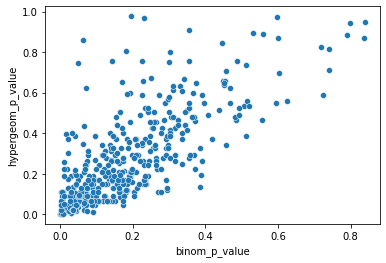

In [14]:
great.pl.scatterplot(
    enrichment,
    "binom_p_value",
    "hypergeom_p_value",
    minus_log10=False)

#### III.1.b With log scale

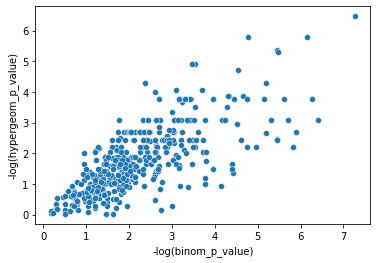

In [15]:
great.pl.scatterplot(
    enrichment,
    "binom_p_value",
    "hypergeom_p_value",
    minus_log10=True)

Resembling the images of the articule published by the Berjano lab: https://www.nature.com/articles/nbt.1630/figures/2

### III.2 With fdr correction

#### III.2.a without log scale

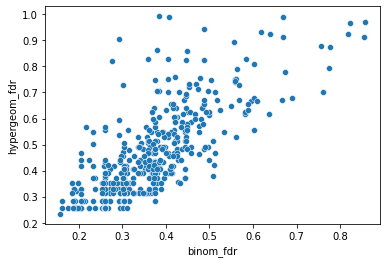

In [17]:
great.pl.scatterplot(
    enrichment,
    "binom_fdr",
    "hypergeom_fdr",
    minus_log10=False)


#### III.2.b with log scale

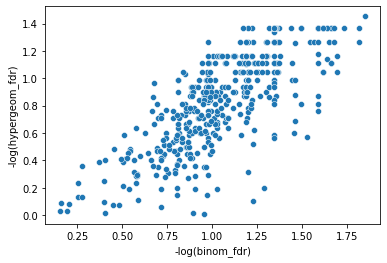

In [18]:
great.pl.scatterplot(
    enrichment,
    "binom_fdr",
    "hypergeom_fdr",
    minus_log10=True)

### III.3 With bonferroni correction

#### III.3.a without log scale

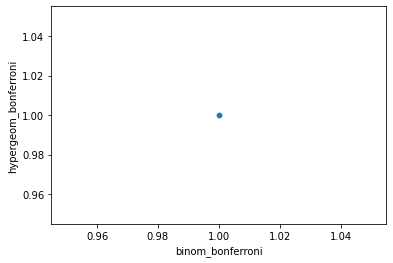

In [19]:
great.pl.scatterplot(
    enrichment,
    "binom_bonferroni",
    "hypergeom_bonferroni",
    minus_log10=False)

#### III.3.b with log scale

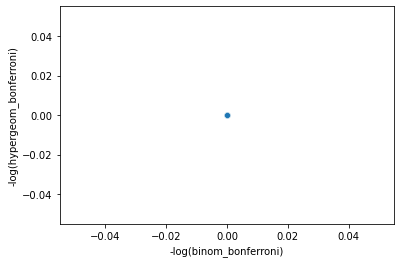

In [20]:
great.pl.scatterplot(
    enrichment,
    "binom_bonferroni",
    "hypergeom_bonferroni",
    minus_log10=True)

We observe that the two probability values returned by greatpy (binomial and hypergeometric) are very different. According to the documentation of Great : 

By default, GREAT ranks results by the binomial p-value, and we consider this the single best way to examine genome-wide cis-regulatory datasets. It accounts for biases in gene regulatory domain size and provides an accurate picture of the cis-regulatory landscape. (https://great-help.atlassian.net/wiki/spaces/GREAT/pages/655456/Statistics) 